goal here is to measure species differences in terms of anomalies instead of absolutes!!

Things to do to adjust model:

3) look at emergent kernel functions?
4) create a model with GENERAL size and growth functions
4a) then model the anomalies from that
5) include additional feature - introduce some hierarchy 
  New grouping variable  - if we set the species to a value that doesnt make sense (null or -1), can the zero grouping capture the general pattern?
  have a genus level encoding too? presumably, we can get genus level curves
  Add additional encoding 

In [2]:
# most basic imports that I would need, need more to visualize
import numpy as np
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as mpl
from random import randint, choice

In [3]:
t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# simplify columns and column names
expected_labels = t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})
featurest1 = t1[['treeID', 'sp', 'dbh']]
featurest1 = featurest1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

# encode the species into binary features and drop rows with any NaN values
encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)
featurest1 = encoder.fit_transform(featurest1)

df_combined = pd.concat([featurest1, expected_labels], axis=1)
df_combined_clean = df_combined.dropna()

# split back up and convert the dataframes to numpy arrays
df_clean = df_combined_clean[featurest1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

# NEW CODE HEREEE!!!!
def round_dbh(num): 
    return 5 * round(num/5)

df_clean.dbh1 = df_clean.dbh1.apply(round_dbh)

featurest1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

featurest1 = featurest1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

# ensure that there is only positive growth, represented by CHANGE (not total dbh)
expected_labels[:,1] = expected_labels[:,1] - featurest1[:,10]
expected_labels = np.where (expected_labels<0, 0, expected_labels)

/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_87162/1453384739.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_87162/1453384739.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_87162/1453384739.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dbh1 = df_clean.dbh1.apply(round_dbh)


1) Create bins for the data - limit noise (round all data to the nearest 5 mm, randomizing whether it rounds up or down) - DONE ABOVE without randomization, just rounding to the nearest 5

THEN train rf and xgb on alllll of the data:

In [4]:
# trained on ALL of the data from 1985 to 1990
rf = RandomForestRegressor()
rf.fit(featurest1[:,1:], expected_labels[:,1])

xg = xgb.XGBRegressor()
xg.fit(featurest1[:,1:], expected_labels[:,1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Graph below with the new model and scatterplot and bins

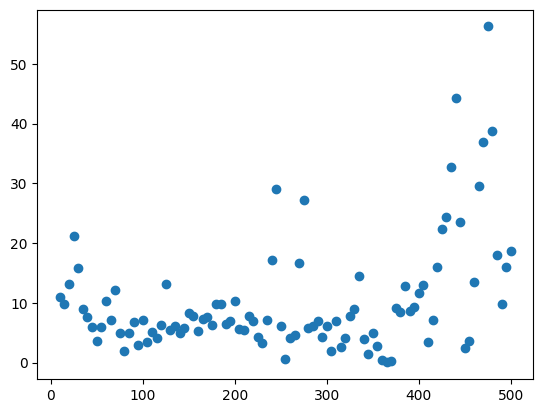

In [6]:
all_dbhs = np.arange(10,501,5).transpose()
sp_label = np.atleast_2d(featurest1[0,1:10])
sp_repeated = np.repeat(sp_label,99,axis=0)
sp_1 = np.column_stack((sp_repeated,all_dbhs))
predictions_sp1 = rf.predict(sp_1)
mpl.scatter(all_dbhs, predictions_sp1)

Create one of these matrices for each species and vstack them ALL

In [11]:
names = encoder.inverse_transform(featurest1)
sp_list = names.sp.unique()
sp_freq = names.sp.value_counts(sort=True).index.tolist()
sp_num = sp_list.shape[0]
sp_mat = np.hstack((np.atleast_2d(sp_list).transpose(), (np.zeros((sp_num, 9)))))

In [35]:
all_dbhs_big = np.arange(10,501,5).transpose()
list_of_all_sp = []

for i in range(sp_num):
    # for each, need to just find the encoding! and append it here!
    # two ways: 
    # 1) look at initial dataset and find the tree with that ID, then find its encoding
    # 2) run through encoder again
    # method 1 used below
    #  id of one tree with that species is provided by names

    # find tree ID of one instance of a species
    tree_id = names[names.sp == sp_freq[i]].treeID1
    one_tree_id = tree_id.iloc[0]
    encoding = featurest1[featurest1[:,0]==one_tree_id][:,1:10]

    sp_label = np.atleast_2d(encoding)
    sp_repeated = np.repeat(sp_label,99,axis=0)
    sp_i = np.column_stack((sp_repeated,all_dbhs))
    all_dbhs_big = np.vstack((all_dbhs_big, all_dbhs))
    list_of_all_sp.append(sp_i)

In [43]:
one_big_array = np.vstack(list_of_all_sp)
all_dbhs_big = (all_dbhs_big.flatten())[:29106]

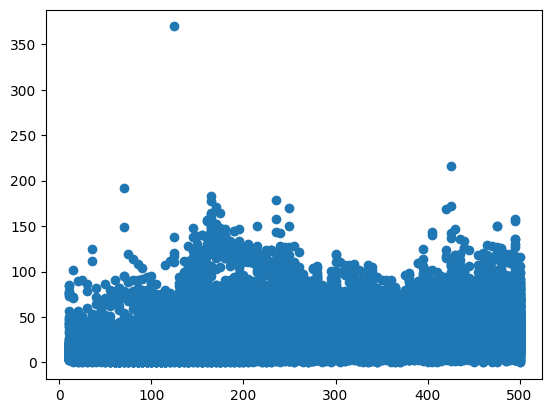

In [47]:
predictions_all_sp = rf.predict(one_big_array)
mpl.scatter(all_dbhs_big, predictions_all_sp)

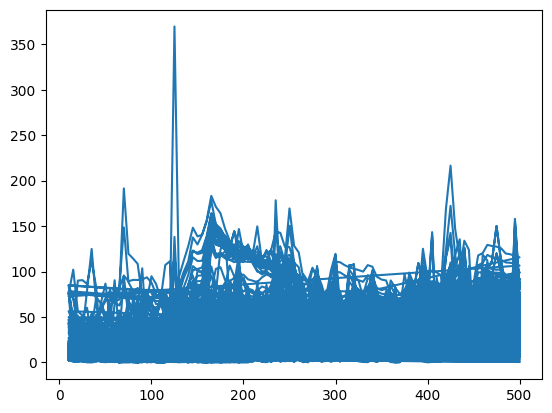

In [46]:
mpl.plot(all_dbhs_big, predictions_all_sp)

In [48]:
list_of_all_preds = []
for sp in list_of_all_sp:
    preds = rf.predict(sp)
    list_of_all_preds.append(preds)

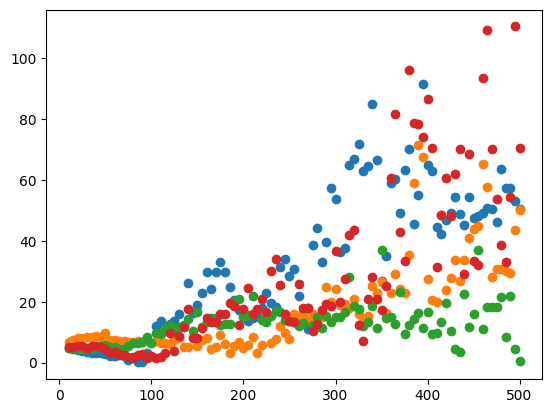

In [62]:

mpl.scatter(all_dbhs,list_of_all_preds[0], label = "Dataset"+str(0))
mpl.scatter(all_dbhs,list_of_all_preds[1], label = "Dataset"+str(1))
mpl.scatter(all_dbhs,list_of_all_preds[2], label = "Dataset"+str(2))
mpl.scatter(all_dbhs,list_of_all_preds[3], label = "Dataset"+str(3))

IndexError: list index out of range

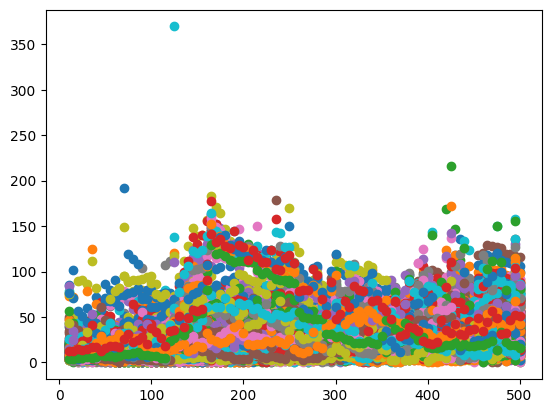

In [63]:
for i in range(np.size(list_of_all_preds)):
    sp= list_of_all_preds[i]
    plot1 = mpl.scatter(all_dbhs,list_of_all_preds[i], label = "Dataset"+str(i))

Ignore species!!! (create a general model)

In [65]:
t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# simplify columns and column names
expected_labels = t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})
featurest1 = t1[['treeID', 'dbh']]
featurest1 = featurest1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

df_combined = pd.concat([featurest1, expected_labels], axis=1)
df_combined_clean = df_combined.dropna()

# split back up and convert the dataframes to numpy arrays
df_clean = df_combined_clean[featurest1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

# NEW CODE HEREEE!!!!
def round_dbh(num): 
    return 5 * round(num/5)

df_clean.dbh1 = df_clean.dbh1.apply(round_dbh)

featurest1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

featurest1 = featurest1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

# ensure that there is only positive growth, represented by CHANGE (not total dbh)
expected_labels[:,1] = expected_labels[:,1] - featurest1[:,1]
expected_labels = np.where (expected_labels<0, 0, expected_labels)

/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_87162/1388651575.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_87162/1388651575.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_87162/1388651575.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dbh1 = df_clean.dbh1.apply(round_dbh)


In [66]:
rf2 = RandomForestRegressor()
rf2.fit(featurest1[:,1:], expected_labels[:,1])

xg2 = xgb.XGBRegressor()
xg2.fit(featurest1[:,1:], expected_labels[:,1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [68]:
all_dbhs = all_dbhs.reshape(-1, 1)
predictions_no_sp = rf2.predict(all_dbhs)

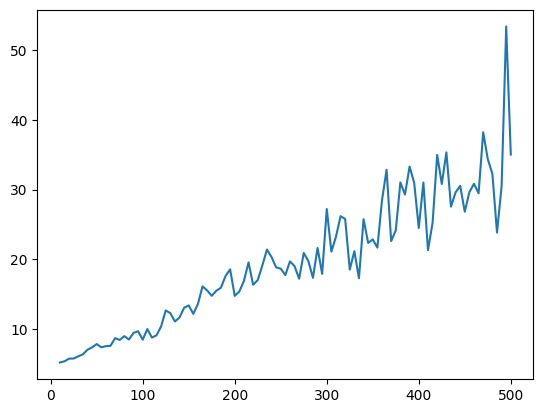

In [69]:
mpl.plot(all_dbhs, predictions_no_sp)